# HW 2 - Evolutionary Computing

## Genetic Algorithms

### Team

Raquel Cossío Ramírez - A01568041

Marie-Amélie Aymon - A01831591


In [4]:
# Import necessary libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd


Implement a genetic algorithm from scratch using both binary and real number encoding.

||**Binary encoding**|**Real encoding**|
|---|---|---|
|**Initialization**|Random|Random|
|**Crossover**.         Pc=0.9|Single point crossover|Simulated Binary Crossover (SBX).     nc=20|
|**Mutation**.          Pm=1/n|Binary mutation|Parameter-based Mutation (PM)        nm=20|
|**Selection**|Roulette wheel selection|Binary tournament (deterministic)|

Test your algorithm by solving the following two optimization problems

1. **Test problem 1:** $f(x_1,x_2) = 100(x_1^2-x_2)^2+(1-x_1)^2$  where $-2.048 \le x_1,x_2 \le 2.048$.  
2. **Rastrigin function:**  $f(\mathbf{x})= A n +\sum_{i=1}^{n}[x_i^2-A \cos{(2\pi x_i)}]$ where $A = 10$ and $x_i \in [-5.12,5.12]$

In [5]:
# Problems

def test_problem1(x):
    # Accepts x as a list or tuple [x1, x2]
    x1, x2 = x
    return 100 * (x1**2 - x2)**2 + (1 - x1) ** 2

def rastrigin(x):
    A = 10
    n = len(x)
    return A * n + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

In [6]:
# Helper function for bounds
def get_bounds(problem, n_var):
    if problem == "test1":
        return [(-2.048, 2.048)] * n_var
    elif problem == "rastrigin":
        return [(-5.12, 5.12)] * n_var
    else:
        raise ValueError("Unknown problem")

In [7]:
# Encoding helpers

def decode_binary(bits, bounds, precision=4):
    # Decode bitstring to float with given bounds
    l, u = bounds
    intval = int("".join(str(b) for b in bits), 2)
    max_int = 2**len(bits) - 1
    return l + (u - l) * intval / max_int

def encode_binary(x, bounds, n_bits):
    l, u = bounds
    intval = int(round((x - l) / (u - l) * (2**n_bits - 1)))
    return list(bin(intval)[2:].zfill(n_bits))

In [8]:
# Selection

def roulette_wheel_selection(fitness):
    max_val = sum(fitness)
    pick = random.uniform(0, max_val)
    current = 0
    for i, f in enumerate(fitness):
        current += f
        if current > pick:
            return i

def tournament_selection(pop, fitness):
    i, j = random.sample(range(len(pop)), 2)
    return i if fitness[i] < fitness[j] else j

In [9]:
# Crossover

def single_point_crossover(p1, p2):
    if len(p1) <= 1:
        return p1[:], p2[:]
    point = random.randint(1, len(p1)-1)
    return p1[:point] + p2[point:], p2[:point] + p1[point:]

def simulated_binary_crossover(x1, x2, eta=20):
    if random.random() > 0.9:
        return x1, x2
    c1, c2 = [], []
    for i in range(len(x1)):
        u = random.random()
        if u <= 0.5:
            beta = (2 * u) ** (1.0 / (eta + 1))
        else:
            beta = (1.0 / (2.0 * (1.0 - u))) ** (1.0 / (eta + 1))
        c1.append(0.5 * ((1 + beta) * x1[i] + (1 - beta) * x2[i]))
        c2.append(0.5 * ((1 - beta) * x1[i] + (1 + beta) * x2[i]))
    return c1, c2


In [10]:
# Mutation

def binary_mutation(bitstring, pm):
    return [str(1-int(b)) if random.random() < pm else b for b in bitstring]

def polynomial_mutation(x, bounds, eta=20, pm=None):
    y = []
    n = len(x)
    if pm is None:
        pm = 1.0 / n
    for i in range(n):
        if random.random() < pm:
            l, u = bounds[i]
            delta1 = (x[i] - l) / (u - l)
            delta2 = (u - x[i]) / (u - l)
            rand = random.random()
            mut_pow = 1.0 / (eta + 1.)
            if rand < 0.5:
                xy = 1.0 - delta1
                val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta + 1))
                deltaq = val**mut_pow - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta + 1))
                deltaq = 1.0 - val**mut_pow
            xi = x[i] + deltaq * (u - l)
            xi = min(max(xi, l), u)
            y.append(xi)
        else:
            y.append(x[i])
    return y

In [11]:
# Genetic Algorithm

def genetic_algorithm(
    func, bounds, n_var, encoding="real", n_bits=16, pop_size=50, generations=100,
    mutation_rate=None, crossover_rate=0.9, selection="default"
):
    if mutation_rate is None:
        mutation_rate = 1.0 / (n_bits * n_var) if encoding == "binary" else 1.0 / n_var

    # Initialize population
    if encoding == "binary":
        chrom_length = n_bits * n_var
        population = [[str(random.randint(0,1)) for _ in range(chrom_length)] for _ in range(pop_size)]
    else:
        population = [np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds]).tolist() for _ in range(pop_size)]

    best_per_gen = []

    for gen in range(generations):
        # Decode & fitness
        if encoding == "binary":
            decoded = []
            for chrom in population:
                vars_ = []
                for i in range(n_var):
                    bits = chrom[i*n_bits:(i+1)*n_bits]
                    vars_.append(decode_binary(bits, bounds[i]))
                decoded.append(vars_)
        else:
            decoded = population

        fitness = [func(ind) for ind in decoded]
        best_idx = np.argmin(fitness)
        best_per_gen.append(fitness[best_idx])

        # New population
        new_pop = []
        while len(new_pop) < pop_size:
            # Selection
            if encoding == "binary":
                if selection == "roulette" or selection == "default":
                    select = lambda fit: roulette_wheel_selection([1/(f+1e-6) for f in fit])
                elif selection == "tournament":
                    select = lambda fit: tournament_selection(population, fit)
                else:
                    raise ValueError("Unknown selection strategy")
                p1 = population[select(fitness)]
                p2 = population[select(fitness)]
                # Crossover
                if random.random() < crossover_rate:
                    c1, c2 = single_point_crossover(p1, p2)
                else:
                    c1, c2 = p1[:], p2[:]
                # Mutation
                c1 = binary_mutation(c1, mutation_rate)
                c2 = binary_mutation(c2, mutation_rate)
                new_pop.extend([c1, c2])
            else:
                if selection == "tournament" or selection == "default":
                    select = lambda fit: tournament_selection(population, fit)
                elif selection == "roulette":
                    select = lambda fit: roulette_wheel_selection([1/(f+1e-6) for f in fit])
                else:
                    raise ValueError("Unknown selection strategy")
                p1 = population[select(fitness)]
                p2 = population[select(fitness)]
                # Crossover
                if random.random() < crossover_rate:
                    c1, c2 = simulated_binary_crossover(p1, p2)
                else:
                    c1, c2 = p1[:], p2[:]
                # Mutation
                c1 = polynomial_mutation(c1, bounds, pm=mutation_rate)
                c2 = polynomial_mutation(c2, bounds, pm=mutation_rate)
                new_pop.extend([c1, c2])
        population = new_pop[:pop_size]
    return best_per_gen



2. Obtain the mean and standard deviation by considering the 20 runs. 

In [22]:
def run_experiments():
    problems = [
        ("test1", test_problem1, 2, "NA"),
        ("rastrigin", rastrigin, 2, 2),
        ("rastrigin", rastrigin, 5, 5)
    ]
    generations = 50  # Default number of generations
    n_bits = 16       # 4 digits precision for binary encoding

    results = []
    for prob_name, func, n_var, n_val in problems:
        bounds = get_bounds(prob_name, n_var)
        for encoding in ["binary", "real"]:
            for run in range(1, 21):
                res = genetic_algorithm(func, bounds, n_var=n_var, encoding=encoding, n_bits=n_bits, generations=generations)
                result = res[-1]
                results.append({
                    "experiment_number": run,
                    "encoding": encoding,
                    "objective_function": prob_name,
                    "n": n_val,
                    "result": result
                })
    df = pd.DataFrame(results)
    return df

df_results = run_experiments()
df_results

,experiment_number,encoding,objective_function,n,result
0,1,binary,test1,NA,0.011431
1,2,binary,test1,NA,0.243107
2,3,binary,test1,NA,0.006408
3,4,binary,test1,NA,0.080868
4,5,binary,test1,NA,0.029279
...,...,...,...,...,...
115,16,real,rastrigin,5,4.016126
116,17,real,rastrigin,5,9.044351
117,18,real,rastrigin,5,8.860050
118,19,real,rastrigin,5,16.484550


In [27]:
summary = df_results.groupby(['encoding', 'objective_function', 'n']).agg(
    mean_result=('result', 'mean'),
    std_result=('result', 'std'),
    min_result=('result', 'min'),
    max_result=('result', 'max')
).reset_index()
summary

,encoding,objective_function,n,mean_result,std_result,min_result,max_result
0,binary,rastrigin,2,0.215492,0.444317,2.421852e-06,1.288519
1,binary,rastrigin,5,4.968709,2.237531,1.177490e+00,8.241879
2,binary,test1,NA,0.118782,0.244266,1.331385e-07,1.023384
3,real,rastrigin,2,1.804179,1.177724,1.152328e-01,4.200274
4,real,rastrigin,5,9.241776,4.379823,4.016126e+00,18.810949
5,real,test1,NA,0.138724,0.130719,3.766391e-03,0.498454


3. Build a **convergence graph** by plotting the best individual fitness value (y-axis) per generation (x-axis) as the verbose mode of your algorithm; use this plot to estimate in which generation you should stop the algorithm. Once the number of generations is determined for each problem, use it for every run.

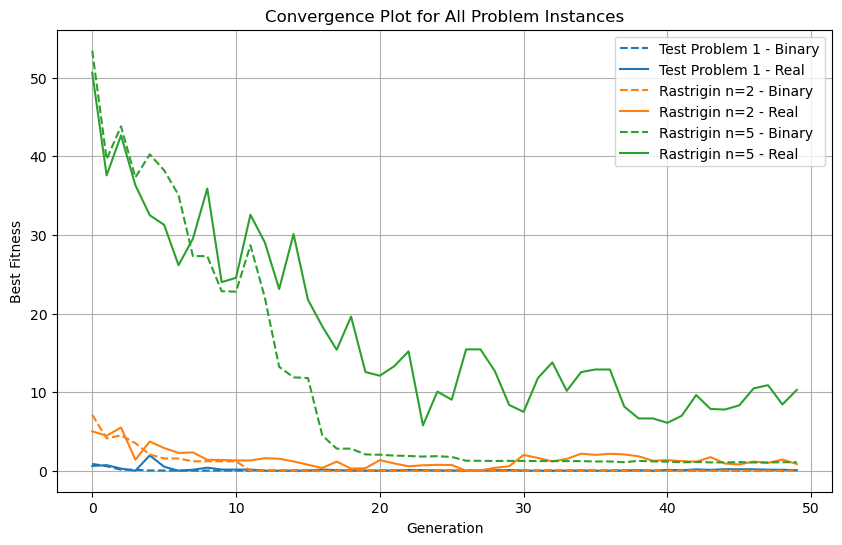

In [24]:
plt.figure(figsize=(10,6))
problems = [
    ("test1", test_problem1, 2, "Test Problem 1"),
    ("rastrigin", rastrigin, 2, "Rastrigin n=2"),
    ("rastrigin", rastrigin, 5, "Rastrigin n=5")
]
encodings = [("binary", "Binary"), ("real", "Real")]
colors = ["tab:blue", "tab:orange", "tab:green"]
linestyles = ["--", "-"]

for i, (prob_name, func, n_var, label) in enumerate(problems):
    bounds = get_bounds(prob_name, n_var)
    for j, (encoding, enc_label) in enumerate(encodings):
        best_per_gen = genetic_algorithm(
            func, bounds, n_var=n_var, encoding=encoding, generations=50, mutation_rate=None
        )
        plt.plot(best_per_gen, color=colors[i], linestyle=linestyles[j],
                 label=f"{label} - {enc_label}")

plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Convergence Plot for All Problem Instances")
plt.legend()
plt.grid(True)
plt.show()

Looks like 25 generations its enough for all problems to converge.

In [33]:
def run_experiments():
    problems = [
        ("test1", test_problem1, 2, "NA"),
        ("rastrigin", rastrigin, 2, 2),
        ("rastrigin", rastrigin, 5, 5)
    ]
    generations = 30  # Set according to convergence plot
    n_bits = 16       # 4 digits precision for binary encoding

    results = []
    for prob_name, func, n_var, n_val in problems:
        bounds = get_bounds(prob_name, n_var)
        for encoding in ["binary", "real"]:
            for run in range(1, 21):
                res = genetic_algorithm(func, bounds, n_var=n_var, encoding=encoding, n_bits=n_bits, generations=generations)
                result = res[-1]
                results.append({
                    "experiment_number": run,
                    "encoding": encoding,
                    "objective_function": prob_name,
                    "n": n_val,
                    "result": result
                })
    df = pd.DataFrame(results)
    return df

df_results2 = run_experiments()

summary2 = df_results2.groupby(['encoding', 'objective_function', 'n']).agg(
    mean_result=('result', 'mean'),
    std_result=('result', 'std'),
    min_result=('result', 'min'),
    max_result=('result', 'max')
).reset_index()
summary2

,encoding,objective_function,n,mean_result,std_result,min_result,max_result
0,binary,rastrigin,2,0.477542,0.546096,0.000002,1.268546
1,binary,rastrigin,5,7.521861,4.199644,2.817625,16.839833
2,binary,test1,NA,0.171266,0.143145,0.000130,0.421312
3,real,rastrigin,2,1.609358,1.210687,0.098495,4.963222
4,real,rastrigin,5,12.548108,3.675567,4.958002,20.173584
5,real,test1,NA,0.162829,0.123319,0.002632,0.458104


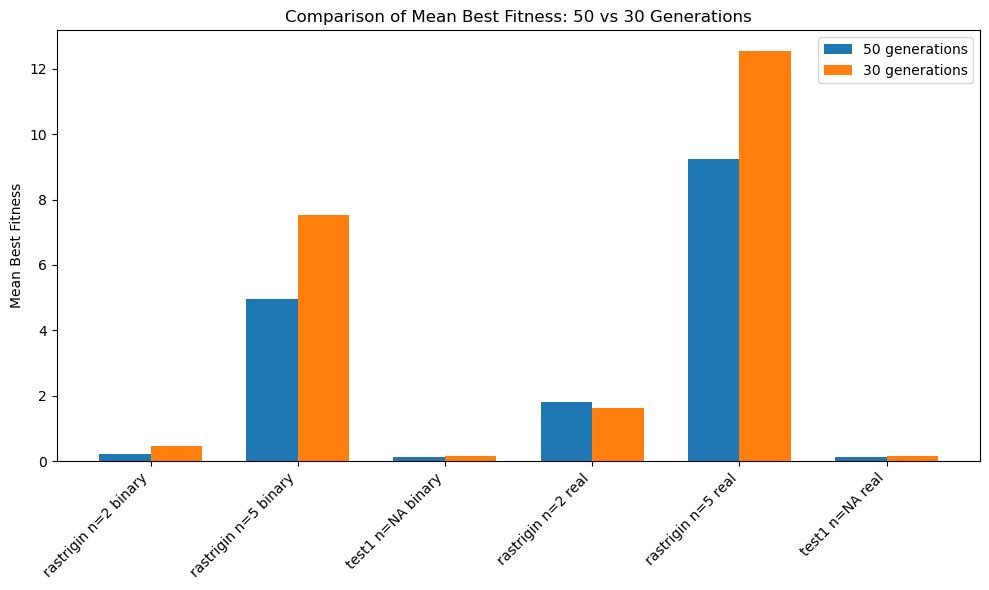

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Merge summaries for comparison
summary['run'] = '50 generations'
summary2['run'] = '30 generations'
df_compare = pd.concat([summary, summary2], ignore_index=True)

# Prepare plot
fig, ax = plt.subplots(figsize=(10,6))

# Create a unique label for each encoding/problem/n
df_compare['label'] = df_compare['objective_function'] + ' n=' + df_compare['n'].astype(str) + ' ' + df_compare['encoding']

labels = df_compare['label'].unique()
x = np.arange(len(labels))
width = 0.35

# Get mean results for each run
means_50 = df_compare[df_compare['run']=='50 generations'].set_index('label')['mean_result'].reindex(labels)
means_25 = df_compare[df_compare['run']=='30 generations'].set_index('label')['mean_result'].reindex(labels)

ax.bar(x - width/2, means_50, width, label='50 generations')
ax.bar(x + width/2, means_25, width, label='30 generations')

ax.set_ylabel('Mean Best Fitness')
ax.set_title('Comparison of Mean Best Fitness: 50 vs 30 Generations')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

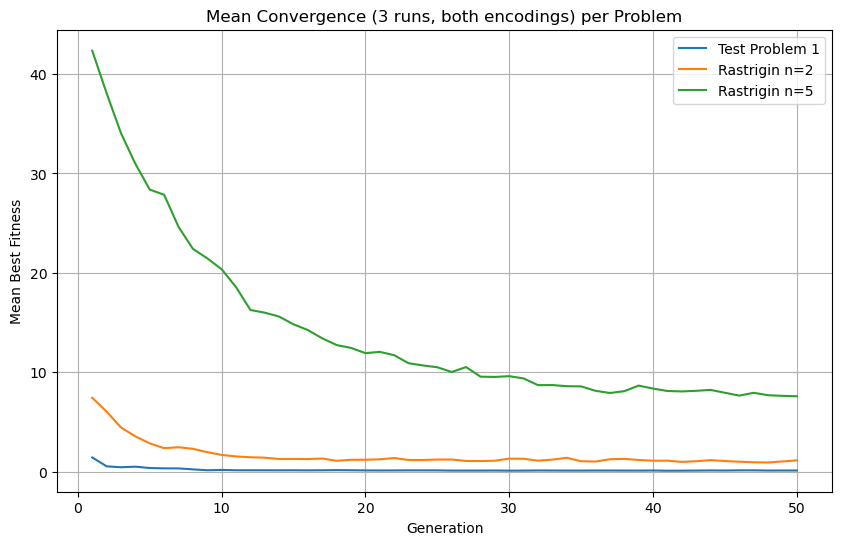

In [40]:
plt.figure(figsize=(10,6))
problems = [
    ("test1", test_problem1, 2, "Test Problem 1"),
    ("rastrigin", rastrigin, 2, "Rastrigin n=2"),
    ("rastrigin", rastrigin, 5, "Rastrigin n=5")
]
encodings = ["binary", "real"]
colors = ["tab:blue", "tab:orange", "tab:green"]

for i, (prob_name, func, n_var, label) in enumerate(problems):
    bounds = get_bounds(prob_name, n_var)
    # Collect mean best fitness per generation for 3 runs (both encodings)
    all_runs = []
    for encoding in encodings:
        for run in range(20):
            best_per_gen = genetic_algorithm(
                func, bounds, n_var=n_var, encoding=encoding, generations=50
            )
            all_runs.append(best_per_gen)
    # Compute mean per generation
    mean_curve = np.mean(np.array(all_runs), axis=0)
    plt.plot(range(1, 51), mean_curve, color=colors[i], label=label)

plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean Convergence (3 runs, both encodings) per Problem")
plt.legend()
plt.grid(True)
plt.show()

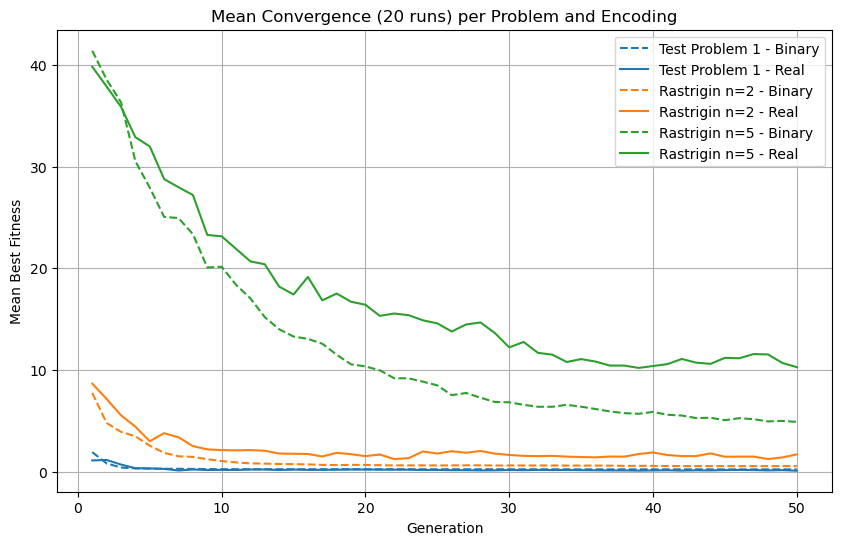

In [41]:
plt.figure(figsize=(10,6))
problems = [
    ("test1", test_problem1, 2, "Test Problem 1"),
    ("rastrigin", rastrigin, 2, "Rastrigin n=2"),
    ("rastrigin", rastrigin, 5, "Rastrigin n=5")
]
encodings = [("binary", "Binary"), ("real", "Real")]
colors = ["tab:blue", "tab:blue", "tab:orange", "tab:orange", "tab:green", "tab:green"]
linestyles = ["--", "-", "--", "-", "--", "-"]

for i, (prob_name, func, n_var, label) in enumerate(problems):
    bounds = get_bounds(prob_name, n_var)
    for j, (encoding, enc_label) in enumerate(encodings):
        all_runs = []
        for run in range(20):
            best_per_gen = genetic_algorithm(
                func, bounds, n_var=n_var, encoding=encoding, generations=50
            )
            all_runs.append(best_per_gen)
        mean_curve = np.mean(np.array(all_runs), axis=0)
        plt.plot(
            range(1, 51), mean_curve,
            color=colors[i*2+j], linestyle=linestyles[i*2+j],
            label=f"{label} - {enc_label}"
        )

plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean Convergence (20 runs) per Problem and Encoding")
plt.legend()
plt.grid(True)
plt.show()

We must stop the genetic algorithm when we meet a plateau. In order to make a more stable line, we used the mean of 20 runs per problem. For Rastrigin n=5 problem, a plateau is met until 50 generations, but for the other problems, we just need 15 generations. Automatically we can compute the average slope of the last 4 generations and if the slope is less than a close to zero-value threshold, let's say, 0.01, then it stops.